In [2]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /var/tmp/pip-req-build-nt851vjv
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /var/tmp/pip-req-build-nt851vjv
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=6992e9531ee96d7f3e40691946d01a21c35fbd8db79c8afbb0ae6e395a55a672
  Stored in directory: /var/tmp/pip-ephem-wheel-cache-o7khw21z/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [4]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np

In [119]:
import sys

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
                    model=sam)

In [262]:
path_to_jsonl = "../../../novice/"
path_to_images = "../../../novice/images/"

In [240]:
image_path = path_to_images + "image_4.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)

In [241]:
print(len(masks))
print(masks[0].keys())

64
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [242]:
masks[0]['bbox']

[0, 617, 840, 251]

In [123]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

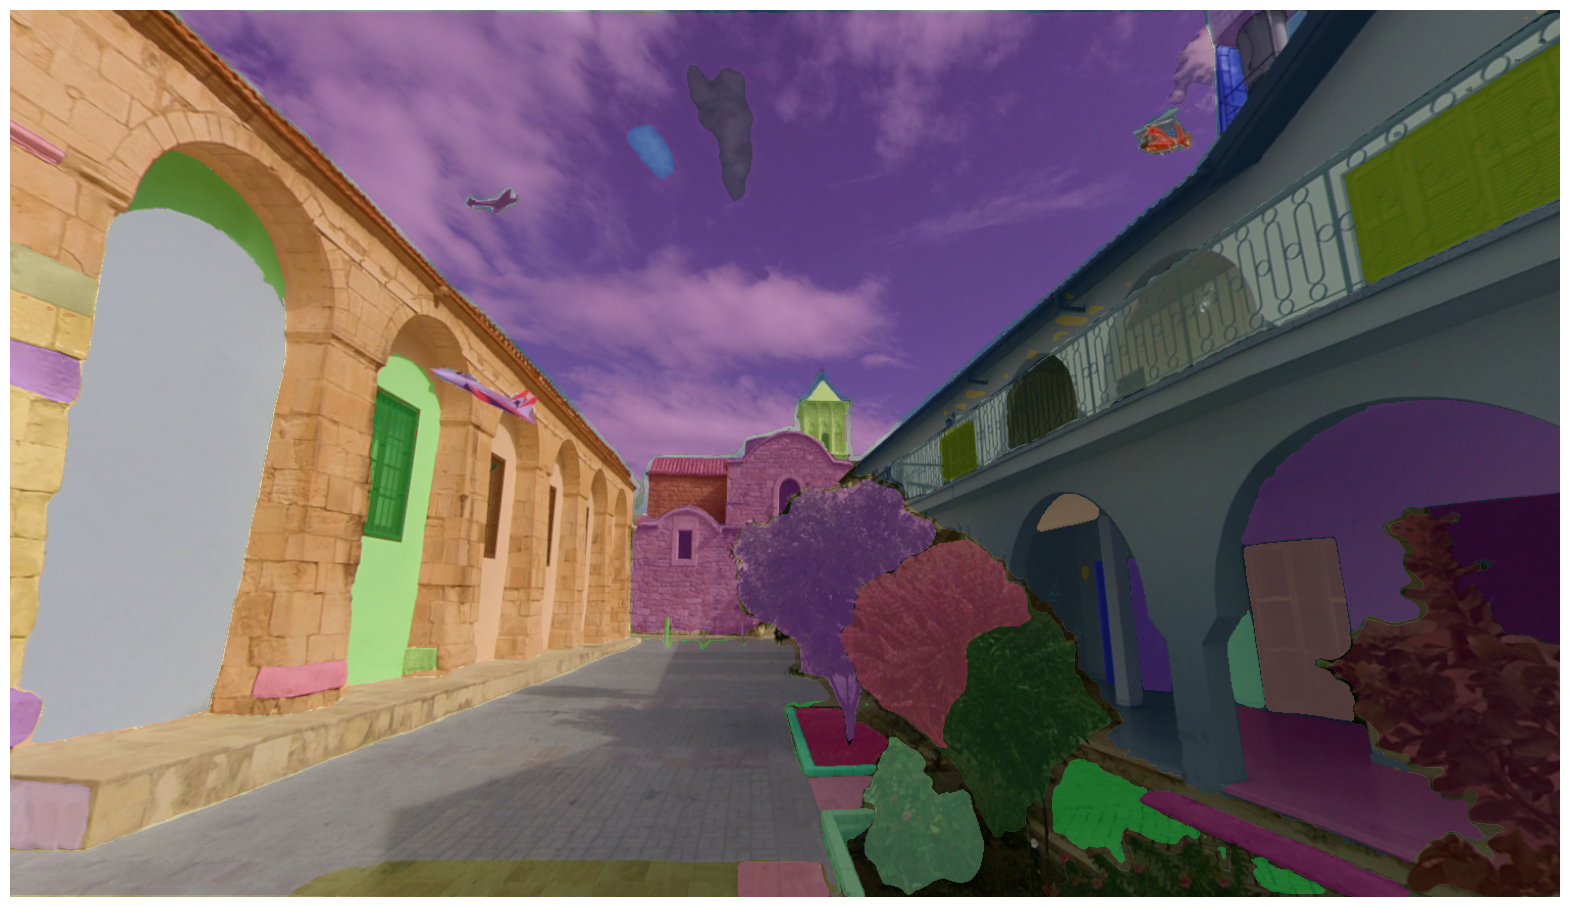

In [243]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [282]:
from PIL import Image

def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    return segmented_image

def crop_with_padding(image, box, padding):
    # Extract coordinates
    x1, y1, x2, y2 = box
    
    # Add padding to the box coordinates
    x1 -= padding
    y1 -= padding
    x2 += padding
    y2 += padding
    
    # Ensure the box doesn't go out of bounds
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(image.width, x2)
    y2 = min(image.height, y2)
    
    # Crop the image with padding
    cropped_image = image.crop((x1, y1, x2, y2))
    
    return cropped_image

# Cut out all masks with padding
image = Image.open(image_path)
cropped_boxes = []
original_bboxes = []
padding = 25  # Adjust the padding value as needed


for mask in masks:
    cropped_box = crop_with_padding(image, convert_box_xywh_to_xyxy(mask["bbox"]), padding)
    cropped_boxes.append(cropped_box)
    original_bboxes.append(mask["bbox"])
    
    
# Can still go back to mask["bbox"] for the original bbox segment

In [233]:
# Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/32", device=device)

In [250]:
@torch.no_grad()
def retriev(elements: list[Image.Image], search_text: str) -> int:
    # Parsed through ClipProcessor
    preprocessed_images = [preprocess(image).to(device) for image in elements]
    
    # Tokenise Text using ClipTokeniser
    tokenized_text = clip.tokenize([search_text]).to(device)
    
    stacked_images = torch.stack(preprocessed_images)
    print(stacked_images.shape)
    
    image_features = model.encode_image(stacked_images)
    text_features = model.encode_text(tokenized_text)
    
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    probs = 100. * image_features @ text_features.T
    return probs[:, 0].softmax(dim=0)

In [251]:
def get_indices_of_values_above_threshold(values, threshold):
    return [i for i, v in enumerate(values) if v > threshold]

torch.Size([64, 3, 224, 224])


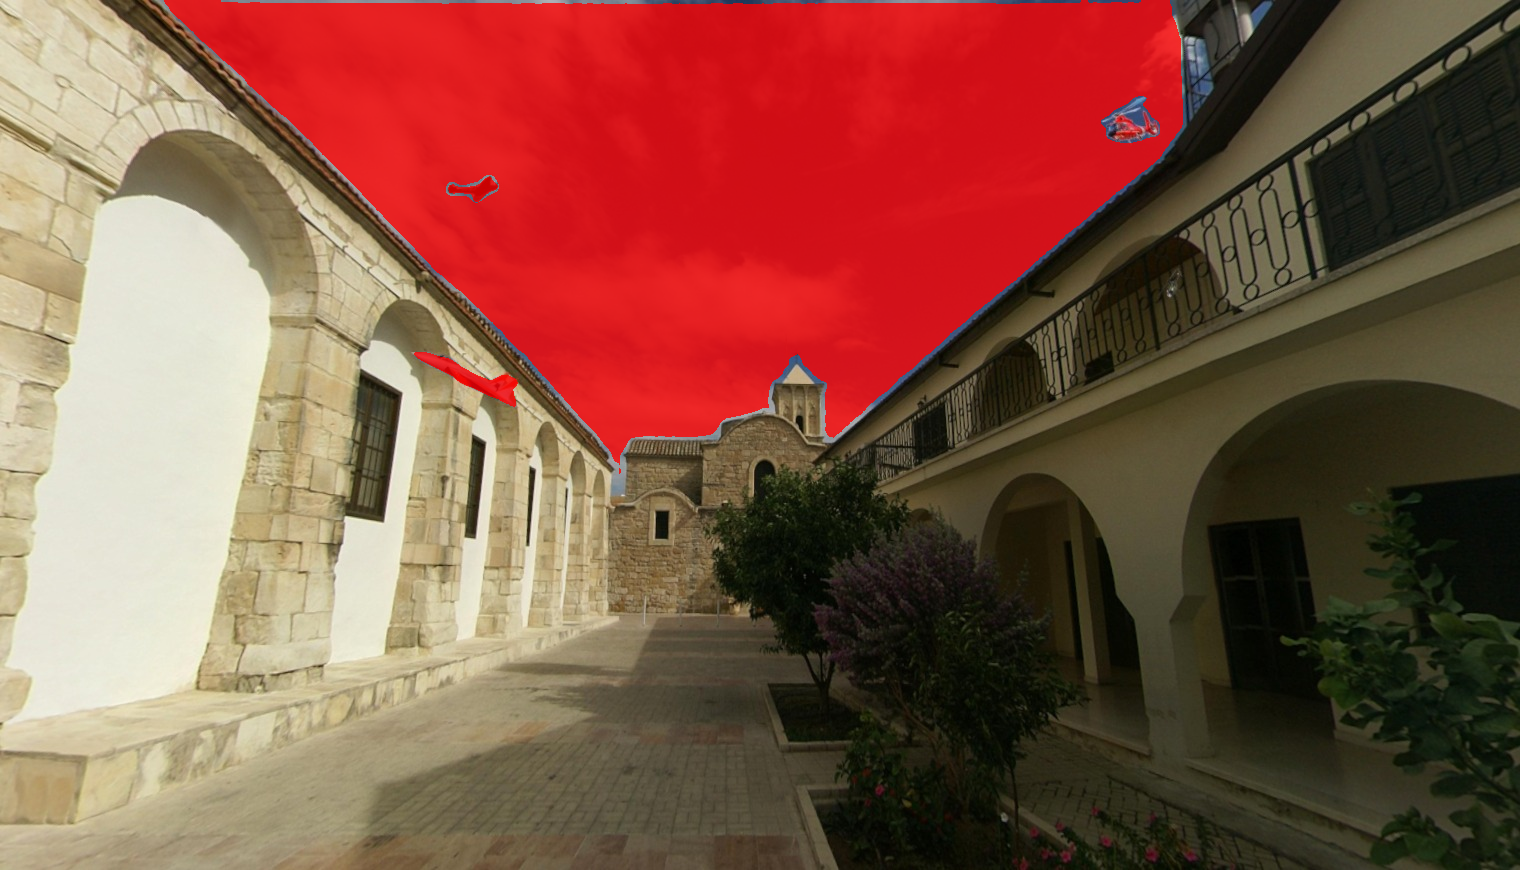

In [279]:
scores = retriev(resized_images, "grey and red fighter jet")
indices = get_indices_of_values_above_threshold(scores, 0.05)

segmentation_masks = []

for seg_idx in indices:
    segmentation_mask_image = Image.fromarray(masks[seg_idx]["segmentation"].astype('uint8') * 255)
    segmentation_masks.append(segmentation_mask_image)

original_image = Image.open(image_path)
overlay_image = Image.new('RGBA', image.size, (0, 0, 0, 0))
overlay_color = (255, 0, 0, 200)

draw = ImageDraw.Draw(overlay_image)
for segmentation_mask_image in segmentation_masks:
    draw.bitmap((0, 0), segmentation_mask_image, fill=overlay_color)

result_image = Image.alpha_composite(original_image.convert('RGBA'), overlay_image)
result_image

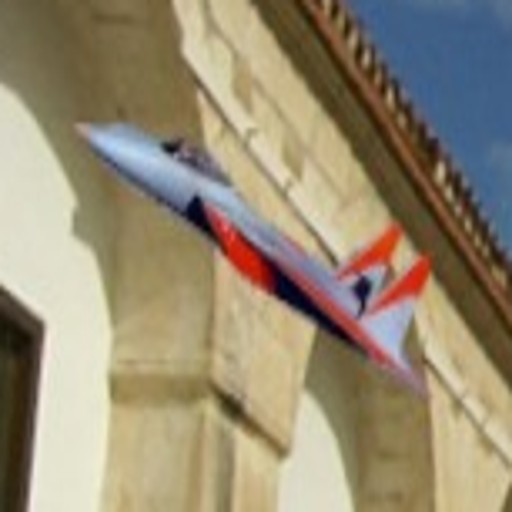

In [280]:
resized_images[np.argmax(scores.cpu())]

{'image': 'image_4.jpg', 'annotations': [{'caption': 'red helicopter', 'bbox': [1100, 96, 60, 52]}, {'caption': 'green and black camouflage helicopter', 'bbox': [1156, 268, 28, 32]}, {'caption': 'grey and red fighter jet', 'bbox': [412, 352, 108, 56]}, {'caption': 'black fighter plane', 'bbox': [448, 176, 52, 24]}]}


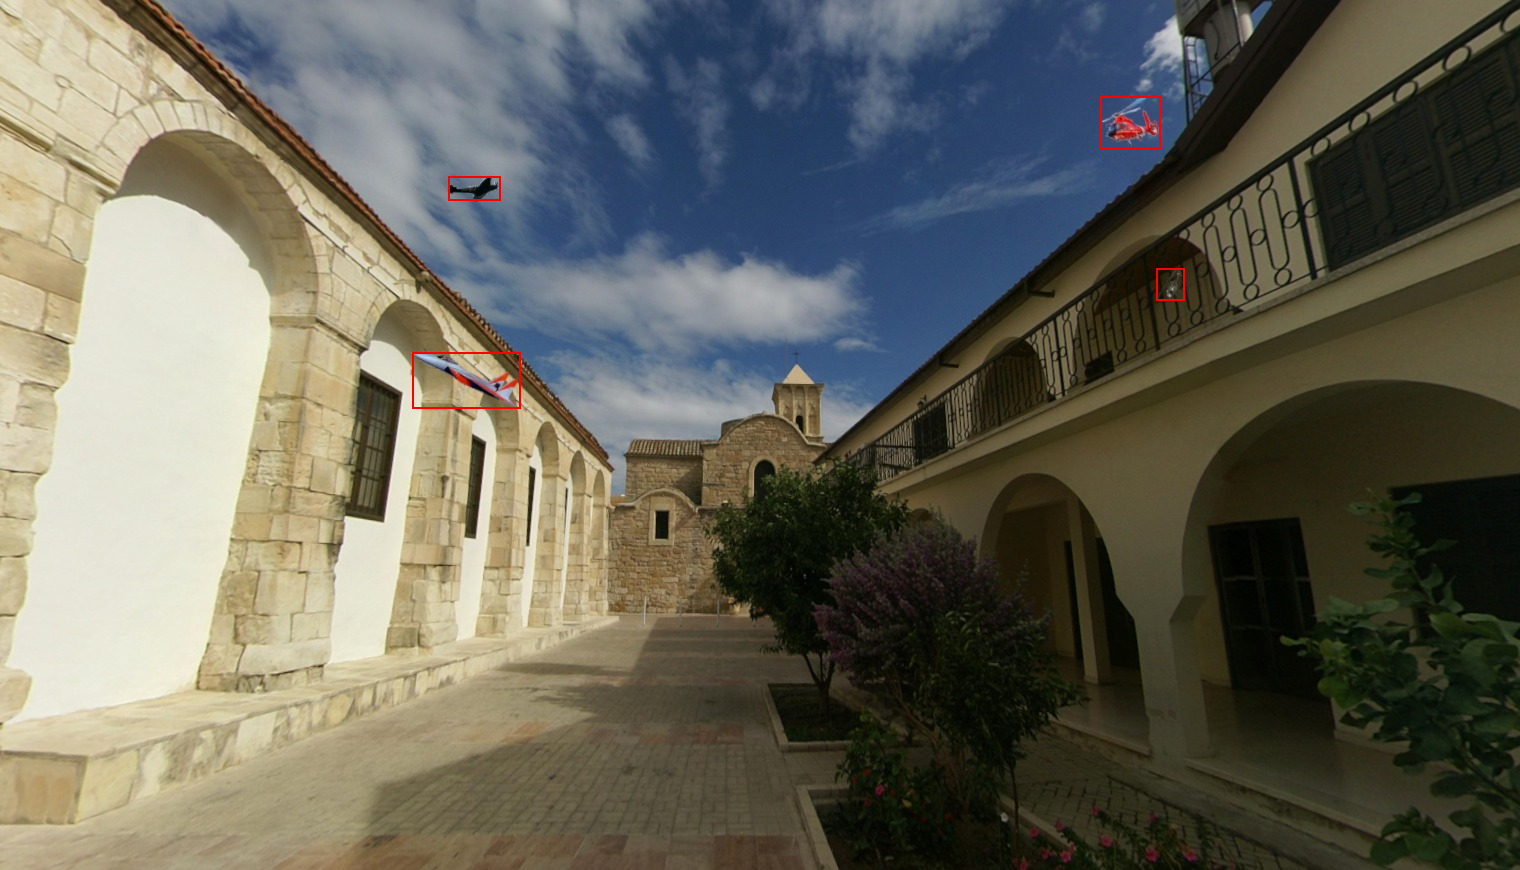

In [287]:
import json

# Load JSONL file
jsonl_file = path_to_jsonl + "vlm.jsonl"
with open(jsonl_file, "r") as f:
    annotations = [json.loads(line) for line in f]
    
image4 = annotations[4]
print(annotations[4])

# Function to draw bounding boxes on an image
def draw_boxes(image_path, annotations):
    # Open the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # Draw bounding boxes
    for annotation in annotations:
        bbox = annotation["bbox"]
        # Convert XYWH to XYXY format
        x1, y1 = bbox[0], bbox[1]
        x2, y2 = x1 + bbox[2], y1 + bbox[3]
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
    
    return image

image_path = path_to_images + image4["image"]
bbox_annotations = image4["annotations"]
draw_boxes(image_path, bbox_annotations)


In [ ]:
original_bboxes